In [1]:
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
import seaborn as sns
import env
from sklearn import metrics

In [2]:
url = env.get_db_url('logs')

In [3]:
df = pd.read_sql('select * from api_access;', url)

In [4]:
df.head()

,entry
0,"97.105.19.58 - - [16/Apr/2019:19:34:42 +0000] ""GET /api/v1/sales?page=81 HTTP/1.1"" 200..."
1,"97.105.19.58 - - [16/Apr/2019:19:34:42 +0000] ""GET /api/v1/items HTTP/1.1"" 200 3561 ""-..."
2,"97.105.19.58 - - [16/Apr/2019:19:34:44 +0000] ""GET /api/v1/sales?page=82 HTTP/1.1"" 200..."
3,"97.105.19.58 - - [16/Apr/2019:19:34:46 +0000] ""GET /api/v1/sales?page=83 HTTP/1.1"" 200..."
4,"97.105.19.58 - - [16/Apr/2019:19:34:48 +0000] ""GET /api/v1/sales?page=84 HTTP/1.1"" 200..."


In [5]:
df['entry'][0]

'97.105.19.58 - - [16/Apr/2019:19:34:42 +0000] "GET /api/v1/sales?page=81 HTTP/1.1" 200 512495 "-" "python-requests/2.21.0"'

In [6]:
df['entry'][1]

'97.105.19.58 - - [16/Apr/2019:19:34:42 +0000] "GET /api/v1/items HTTP/1.1" 200 3561 "-" "python-requests/2.21.0"'

In [7]:
# 200 is the status code
# 3561 is the size in bites
# "python-requests/2.21.0"' is the requester

In [8]:
parts = df['entry'][0].split()

In [9]:
parts

['97.105.19.58',
 '-',
 '-',
 '[16/Apr/2019:19:34:42',
 '+0000]',
 '"GET',
 '/api/v1/sales?page=81',
 'HTTP/1.1"',
 '200',
 '512495',
 '"-"',
 '"python-requests/2.21.0"']

In [10]:
output = {}
output['ip'] = parts[0]
output['timestamp'] = parts[3][1:].replace(';', ' ', 1)
output

{'ip': '97.105.19.58', 'timestamp': '16/Apr/2019:19:34:42'}

In [11]:
# function to deal with parsing one entry in our log data
def parse_log_entry(entry):
    parts = entry.split()
    output = {}
    output['ip'] = parts[0]
    output['timestamp'] = parts[3][1:].replace(':', ' ', 1)
    output['request_method'] = parts[5][1:]
    output['request_path'] = parts[6]
    output['http_version'] = parts[7][:-1]
    output['status_code'] = parts[8]
    output['size'] = int(parts[9])
    output['user_agent'] = ' '.join(parts[11:]).replace('"', '')
    return pd.Series(output)


# df = pd.concat([df.entry, df.entry.apply(parse_log_entry)], axis=1)
df = df.entry.apply(parse_log_entry)
df.head()


,ip,timestamp,request_method,request_path,http_version,status_code,size,user_agent
0,97.105.19.58,16/Apr/2019 19:34:42,GET,/api/v1/sales?page=81,HTTP/1.1,200,512495,python-requests/2.21.0
1,97.105.19.58,16/Apr/2019 19:34:42,GET,/api/v1/items,HTTP/1.1,200,3561,python-requests/2.21.0
2,97.105.19.58,16/Apr/2019 19:34:44,GET,/api/v1/sales?page=82,HTTP/1.1,200,510103,python-requests/2.21.0
3,97.105.19.58,16/Apr/2019 19:34:46,GET,/api/v1/sales?page=83,HTTP/1.1,200,510003,python-requests/2.21.0
4,97.105.19.58,16/Apr/2019 19:34:48,GET,/api/v1/sales?page=84,HTTP/1.1,200,511963,python-requests/2.21.0


In [12]:
# NEAT

In [13]:
new = pd.DataFrame([
    ["95.31.18.119", "21/Apr/2019 10:02:41", "GET", "/api/v1/items/", "HTTP/1.1", '200', 1153005, "python-requests/2.21.0"],
    ["95.31.16.121", "17/Apr/2019 19:36:41", "GET", "/api/v1/sales?page=79/", "HTTP/1.1", '301', 1005, "python-requests/2.21.0"],
    ["97.105.15.120", "18/Apr/2019 19:42:41", "GET", "/api/v1/sales?page=79/", "HTTP/1.1", '301', 2560, "python-requests/2.21.0"],
    ["97.105.19.58", "19/Apr/2019 19:42:41", "GET", "/api/v1/sales?page=79/", "HTTP/1.1", '200', 2056327, "python-requests/2.21.0"],
], columns=df.columns)

df = df.append(new)


/var/folders/gn/krty7k0175z7_1gpw49cwdch0000gn/T/ipykernel_62839/447971755.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new)


In [14]:
df.tail()

,ip,timestamp,request_method,request_path,http_version,status_code,size,user_agent
13973,97.105.19.58,17/Apr/2019 12:55:14,GET,/api/v1/sales?page=71,HTTP/1.1,200,510166,python-requests/2.21.0
0,95.31.18.119,21/Apr/2019 10:02:41,GET,/api/v1/items/,HTTP/1.1,200,1153005,python-requests/2.21.0
1,95.31.16.121,17/Apr/2019 19:36:41,GET,/api/v1/sales?page=79/,HTTP/1.1,301,1005,python-requests/2.21.0
2,97.105.15.120,18/Apr/2019 19:42:41,GET,/api/v1/sales?page=79/,HTTP/1.1,301,2560,python-requests/2.21.0
3,97.105.19.58,19/Apr/2019 19:42:41,GET,/api/v1/sales?page=79/,HTTP/1.1,200,2056327,python-requests/2.21.0


In [15]:
df['timestamp'] = pd.to_datetime(df.timestamp)
df = df.set_index('timestamp').sort_index()

In [16]:
df['size_mb'] = (df.size / 1024) / 1024

In [17]:
df

,ip,request_method,request_path,http_version,status_code,size,user_agent,size_mb
timestamp,,,,,,,,
2019-04-16 19:34:42,97.105.19.58,GET,/api/v1/sales?page=81,HTTP/1.1,200,512495,python-requests/2.21.0,0.093313
2019-04-16 19:34:42,97.105.19.58,GET,/api/v1/items,HTTP/1.1,200,3561,python-requests/2.21.0,0.093313
2019-04-16 19:34:44,97.105.19.58,GET,/api/v1/sales?page=82,HTTP/1.1,200,510103,python-requests/2.21.0,0.093313
2019-04-16 19:34:46,97.105.19.58,GET,/api/v1/sales?page=83,HTTP/1.1,200,510003,python-requests/2.21.0,0.093313
2019-04-16 19:34:48,97.105.19.58,GET,/api/v1/sales?page=84,HTTP/1.1,200,511963,python-requests/2.21.0,0.093313
...,...,...,...,...,...,...,...,...
2019-04-17 12:55:14,97.105.19.58,GET,/api/v1/sales?page=71,HTTP/1.1,200,510166,python-requests/2.21.0,0.093313
2019-04-17 19:36:41,95.31.16.121,GET,/api/v1/sales?page=79/,HTTP/1.1,301,1005,python-requests/2.21.0,0.093313
2019-04-18 19:42:41,97.105.15.120,GET,/api/v1/sales?page=79/,HTTP/1.1,301,2560,python-requests/2.21.0,0.093313


#### Detecting anomalies in discrete variables

In [18]:
df.ip.value_counts()

97.105.19.58      11999
173.173.113.51     1059
72.181.113.170      613
72.181.105.81       246
68.201.219.223       21
24.26.242.9          21
35.175.171.137        2
52.87.230.102         2
70.121.214.34         2
52.90.165.200         1
97.105.15.120         1
95.31.16.121          1
45.23.250.16          1
52.91.30.150          1
34.207.64.242         1
3.88.129.158          1
54.172.14.223         1
3.92.201.136          1
35.174.209.2          1
54.145.52.184         1
34.229.70.250         1
95.31.18.119          1
Name: ip, dtype: int64

In [19]:
# the ip address with the largest value counts is probably a safe ip address

# The ip addresses with 1 or 2 values may be anomalies

In [20]:
ip_df = pd.DataFrame(df.ip.value_counts(dropna=False)).reset_index().\
    rename(columns={'index': 'ip', 'ip': 'count'})

In [21]:
ip_df

,ip,count
0,97.105.19.58,11999
1,173.173.113.51,1059
2,72.181.113.170,613
3,72.181.105.81,246
4,68.201.219.223,21
5,24.26.242.9,21
6,35.175.171.137,2
7,52.87.230.102,2
8,70.121.214.34,2
9,52.90.165.200,1


In [22]:
ip_df['probability'] = ip_df['count'] / (ip_df['count'].sum())

In [23]:
ip_df

,ip,count,probability
0,97.105.19.58,11999,0.858420
1,173.173.113.51,1059,0.075762
2,72.181.113.170,613,0.043855
3,72.181.105.81,246,0.017599
4,68.201.219.223,21,0.001502
5,24.26.242.9,21,0.001502
6,35.175.171.137,2,0.000143
7,52.87.230.102,2,0.000143
8,70.121.214.34,2,0.000143
9,52.90.165.200,1,0.000072


In [25]:
ip_df = ip_df.set_index('ip').sort_values('count')

<AxesSubplot:ylabel='ip'>

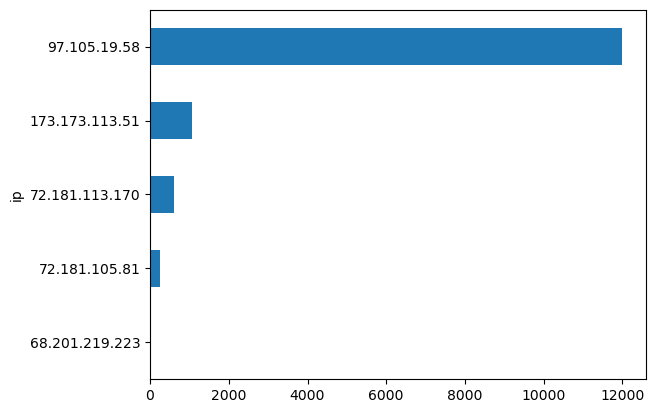

In [28]:
ip_df['count'].tail().plot.barh()

In [29]:
p_a_b = df.groupby(['ip', 'status_code']).size()/len(df)

In [30]:
p_a_b

ip              status_code
173.173.113.51  200            0.075762
24.26.242.9     200            0.001502
3.88.129.158    200            0.000072
3.92.201.136    200            0.000072
34.207.64.242   200            0.000072
34.229.70.250   200            0.000072
35.174.209.2    200            0.000072
35.175.171.137  200            0.000143
45.23.250.16    200            0.000072
52.87.230.102   200            0.000143
52.90.165.200   200            0.000072
52.91.30.150    200            0.000072
54.145.52.184   200            0.000072
54.172.14.223   200            0.000072
68.201.219.223  200            0.001502
70.121.214.34   200            0.000143
72.181.105.81   200            0.017599
72.181.113.170  200            0.043712
                499            0.000143
95.31.16.121    301            0.000072
95.31.18.119    200            0.000072
97.105.15.120   301            0.000072
97.105.19.58    200            0.857419
                499            0.001002
dtype: float

In [32]:
p_b = df.groupby('ip').size()/len(df)

In [33]:
p_a_b / p_b

ip              status_code
173.173.113.51  200            1.000000
24.26.242.9     200            1.000000
3.88.129.158    200            1.000000
3.92.201.136    200            1.000000
34.207.64.242   200            1.000000
34.229.70.250   200            1.000000
35.174.209.2    200            1.000000
35.175.171.137  200            1.000000
45.23.250.16    200            1.000000
52.87.230.102   200            1.000000
52.90.165.200   200            1.000000
52.91.30.150    200            1.000000
54.145.52.184   200            1.000000
54.172.14.223   200            1.000000
68.201.219.223  200            1.000000
70.121.214.34   200            1.000000
72.181.105.81   200            1.000000
72.181.113.170  200            0.996737
                499            0.003263
95.31.16.121    301            1.000000
95.31.18.119    200            1.000000
97.105.15.120   301            1.000000
97.105.19.58    200            0.998833
                499            0.001167
dtype: float

In [34]:
status_given_ip = (
    df.groupby('ip')
    .status_code.value_counts(normalize=True)
    .rename('proba_status_given_ip')
    .reset_index()
)
status_given_ip.head()


,ip,status_code,proba_status_given_ip
0,173.173.113.51,200,1.0
1,24.26.242.9,200,1.0
2,3.88.129.158,200,1.0
3,3.92.201.136,200,1.0
4,34.207.64.242,200,1.0


In [35]:
status_given_ip[status_given_ip.status_code != '200']


,ip,status_code,proba_status_given_ip
18,72.181.113.170,499,0.003263
19,95.31.16.121,301,1.000000
21,97.105.15.120,301,1.000000
23,97.105.19.58,499,0.001167


In [36]:
status_given_ip[status_given_ip.proba_status_given_ip < 1]


,ip,status_code,proba_status_given_ip
17,72.181.113.170,200,0.996737
18,72.181.113.170,499,0.003263
22,97.105.19.58,200,0.998833
23,97.105.19.58,499,0.001167
